In [1]:
# going to use the U-net but instead of useing the standard U-net, i gonna use the pre-trained network (ie. VGG, inception). But this things are mostly very difficult for us to do from scratch, so we gonna use the some python libraries;

# VGG --> came into April, 2015; reference of the original --> https://arxiv.org/abs/1409.1556;
# as you are increasing the depth of the model, you are also increasing no. of trainable parameters, but VGG was degined to reduce the no. of parameters in the convolutional layers and thus imrove the training time;
# VGG19 vs VGG16 --> similar structure but diff. in no. of convolution layers;


# ResNet --> is a CNN made up of series of residual blocks with skip connections; 10 Dec, 2015; reference of the original --> https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html;
# ResNet addresses the Vanishing-Gradient-Problem; -->as we make the CNN deeper, the derivatives becomes almost insignificant when back propagating to the initial layer(0.0001 * 0.0001 = 0.0000001 ... the derivative almost vanishes ) as more layers added, training slows and accuracy gets worse instead of improving;
# this skip connections address this vanishing gradient problem;


# Inception --> 11 Dec, 2015; say into image analysis, i have some features which are at local level( very small features), some ar at global level(big sized features), so when to pick a kernel size into convo. operation, i need the kernel size to match the feature size, so i need a variational kernel size; (large kernels --> global feature/large area of image), (mall kernel --> detecting area specific features(pixels)); inception goes wider, instead of deeper with layers; kernels of diff. sizes used within the same layer;

In [2]:
# what exactly backbone really means ?
# Backbone is the model to be used for the encoder part of the U-net.
# advantages : 1. use the sophesticated architecture, 2. you can import this weights with pretrained weights(ie. on imagenet, means already being taught/trained on imagenet);

In [1]:
# i am gonna use Segmentation Models; --> pip install -U segmentation-models==0.2.1; reference -->https://github.com/qubvel/segmentation_models
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [2]:
SIZE_X = 128 
SIZE_Y = 128
n_classes = 4 # no of classes for segmentation


train_images = [] # Capture training image info as a list

for directory_path in glob.glob(r"D:\Deep Learning\U Net with Transfer Learning\128_patches\images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 1)       
        train_images.append(img)    
train_images = np.array(train_images) #Convert list to array for machine learning processing


train_masks = [] #Capture mask/label info as a list
for directory_path in glob.glob(r"D:\Deep Learning\U Net with Transfer Learning\128_patches\masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        train_masks.append(mask)
train_masks = np.array(train_masks) # Convert list to array for machine learning processing   

In [3]:
train_masks.shape

(1600, 128, 128)

In [4]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))
print(np.unique(train_masks))

C:\python_arpan\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2 3]
[1 2 3 4]


In [5]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [6]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

# #Further split training data t a smaller subset for quick testing of models
# X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

In [7]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


In [8]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [9]:
y_test_cat.shape

(160, 128, 128, 4)

In [14]:
n_classes = 4 # -->class0, c1, c2, c3;
activation = 'softmax'
LR = 0.0001
optim = keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss) # # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses; total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)] # we do not need accuracy, we need IOU Score;

In [14]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)


In [16]:
# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, None, None, 64)       0         ['stage1_unit3_relu1[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage1_unit3_conv1 (Conv2D  (None, None, None, 64)       36864     ['zero_padding2d_6[0][0]']    
 )                                                                                                
                                                                                                  
 stage1_unit3_bn2 (BatchNor  (None, None, None, 64)       256       ['stage1_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage1_un

                                                                                                  
 zero_padding2d_12 (ZeroPad  (None, None, None, 128)      0         ['stage2_unit3_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage2_unit3_conv1 (Conv2D  (None, None, None, 128)      147456    ['zero_padding2d_12[0][0]']   
 )                                                                                                
                                                                                                  
 stage2_unit3_bn2 (BatchNor  (None, None, None, 128)      512       ['stage2_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage2_un

                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit2_relu1[0][0]']  
 ding2D)                                                                                          
                                                                                                  
 stage3_unit2_conv1 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_18[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit2_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_un

 ding2D)                                                                                          
                                                                                                  
 stage3_unit5_conv1 (Conv2D  (None, None, None, 256)      589824    ['zero_padding2d_24[0][0]']   
 )                                                                                                
                                                                                                  
 stage3_unit5_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit5_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit5_relu2 (Activa  (None, None, None, 256)      0         ['stage3_unit5_bn2[0][0]']    
 tion)                                                                                            
          

 ding2D)                                                                                          
                                                                                                  
 stage4_unit2_conv1 (Conv2D  (None, None, None, 512)      2359296   ['zero_padding2d_30[0][0]']   
 )                                                                                                
                                                                                                  
 stage4_unit2_bn2 (BatchNor  (None, None, None, 512)      2048      ['stage4_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage4_unit2_relu2 (Activa  (None, None, None, 512)      0         ['stage4_unit2_bn2[0][0]']    
 tion)                                                                                            
          

 decoder_stage1a_conv (Conv  (None, None, None, 128)      442368    ['decoder_stage1_concat[0][0]'
 2D)                                                                ]                             
                                                                                                  
 decoder_stage1a_bn (BatchN  (None, None, None, 128)      512       ['decoder_stage1a_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage1a_relu (Acti  (None, None, None, 128)      0         ['decoder_stage1a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage1b_conv (Conv  (None, None, None, 128)      147456    ['decoder_stage1a_relu[0][0]']
 2D)      

 decoder_stage4b_bn (BatchN  (None, None, None, 16)       64        ['decoder_stage4b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage4b_relu (Acti  (None, None, None, 16)       0         ['decoder_stage4b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 final_conv (Conv2D)         (None, None, None, 4)        580       ['decoder_stage4b_relu[0][0]']
                                                                                                  
 softmax (Activation)        (None, None, None, 4)        0         ['final_conv[0][0]']          
                                                                                                  
Total para

In [ ]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=3,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('res34_backbone_50epochs.hdf5')

In [17]:
# for loading partially trained model
from keras.models import load_model
new_model = load_model(r"D:\Deep Learning\U Net with Transfer Learning\res34_backbone_50epochs.hdf5", compile=False)

new_model.compile(optim, total_loss, metrics=metrics) # u need to compile the newly loaded model, othwerwise u would not be able to evaluate or train or predict;

# seeing how your model is performing, in case u forgotten
results = new_model.evaluate(X_test1, y_test_cat, steps = 16)
print("Validation loss & accuracy : ", results)

16/16 [==============================] - 11s 512ms/step - loss: 0.8049 - iou_score: 0.8279 - f1-score: 0.9004
Validation loss & accuracy :  [0.8048569560050964, 0.827894389629364, 0.9003979563713074]


In [18]:
history1_updated_by_5 = new_model.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=5,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('res34_backbone_3_+_5_epochs.hdf5')

Epoch 1/5
180/180 [==============================] - 424s 2s/step - loss: 0.7933 - iou_score: 0.8277 - f1-score: 0.8993 - val_loss: 0.7911 - val_iou_score: 0.8332 - val_f1-score: 0.9020
Epoch 2/5
180/180 [==============================] - 417s 2s/step - loss: 0.7858 - iou_score: 0.8433 - f1-score: 0.9095 - val_loss: 0.7821 - val_iou_score: 0.8566 - val_f1-score: 0.9183
Epoch 3/5
180/180 [==============================] - 416s 2s/step - loss: 0.7809 - iou_score: 0.8576 - f1-score: 0.9192 - val_loss: 0.7808 - val_iou_score: 0.8537 - val_f1-score: 0.9168
Epoch 4/5
180/180 [==============================] - 420s 2s/step - loss: 0.7792 - iou_score: 0.8631 - f1-score: 0.9223 - val_loss: 0.7768 - val_iou_score: 0.8722 - val_f1-score: 0.9282
Epoch 5/5
180/180 [==============================] - 420s 2s/step - loss: 0.7759 - iou_score: 0.8754 - f1-score: 0.9304 - val_loss: 0.7752 - val_iou_score: 0.8746 - val_f1-score: 0.9302


C:\python_arpan\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


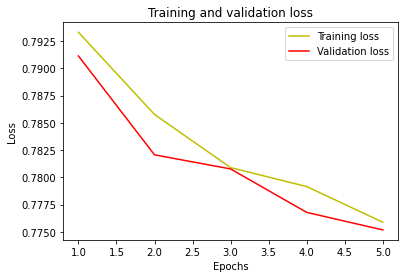

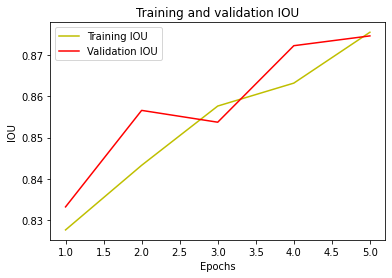

In [19]:
#plot the training and validation accuracy and loss at each epoch of the ResNet34

loss = history1_updated_by_5.history['loss']
val_loss = history1_updated_by_5.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1_updated_by_5.history['iou_score']
val_acc = history1_updated_by_5.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [20]:
#IOU
y_pred1 = new_model.predict(X_test1) 
y_pred1_argmax = np.argmax(y_pred1, axis = 3) 
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

5/5 [==============================] - 9s 2s/step
Mean IoU = 0.88628626


In [21]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)


[[3.28073e+05 1.69710e+04 1.17050e+04 3.00000e+00]
 [7.58700e+03 1.72961e+05 2.11590e+04 0.00000e+00]
 [3.68700e+03 1.32070e+04 1.98302e+06 3.96000e+02]
 [2.00000e+00 0.00000e+00 3.74400e+03 5.89250e+04]]
IoU for class1 is:  0.8914349
IoU for class2 is:  0.7458913
IoU for class3 is:  0.9735394
IoU for class4 is:  0.9342794


1/1 [==============================] - 1s 986ms/step


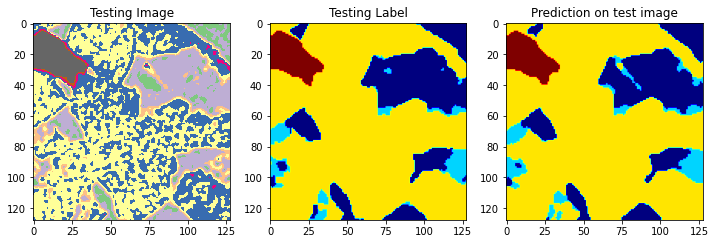

In [22]:
# Test some random images
import random
test_img_number = random.randint(0, len(X_test1))

test_img = X_test1[test_img_number]

ground_truth = y_test[test_img_number]

test_img_input = np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = new_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='Accent')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

In [15]:
# Model 2

initial_learning_rate = 0.0001
decay_rate=0.9
decay_steps=100000
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.9, staircase=True)

optim = keras.optimizers.SGD(learning_rate=lr_schedule)

BACKBONE2 = 'vgg16'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)


# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model2.compile( optim, total_loss, metrics)
#model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                                                                                            

                                                                                                  
 decoder_stage1_upsampling   (None, None, None, 256)      0         ['decoder_stage0b_relu[0][0]']
 (UpSampling2D)                                                                                   
                                                                                                  
 decoder_stage1_concat (Con  (None, None, None, 768)      0         ['decoder_stage1_upsampling[0]
 catenate)                                                          [0]',                         
                                                                     'block4_conv3[0][0]']        
                                                                                                  
 decoder_stage1a_conv (Conv  (None, None, None, 128)      884736    ['decoder_stage1_concat[0][0]'
 2D)                                                                ]                             
          

 ormalization)                                                                                    
                                                                                                  
 decoder_stage4a_relu (Acti  (None, None, None, 16)       0         ['decoder_stage4a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage4b_conv (Conv  (None, None, None, 16)       2304      ['decoder_stage4a_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 decoder_stage4b_bn (BatchN  (None, None, None, 16)       64        ['decoder_stage4b_conv[0][0]']
 ormalization)                                                                                    
          

In [ ]:
history2 = model2.fit(X_train2, 
          y_train_cat,
          batch_size=100, 
          epochs=5,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


model3.save('vgg16_backbone_5_epochs_with_custom_SGD.hdf5')

In [17]:
# for loading partially trained model
from keras.models import load_model
new_model2 = load_model(r"D:\Deep Learning\U Net with Transfer Learning\vgg16_backbone_3_+_5_epochs.hdf5", compile=False)

new_model2.compile(optim, total_loss, metrics=metrics) # u need to compile the newly loaded model, othwerwise u would not be able to evaluate or train or predict;

# seeing how your model is performing, in case u forgotten
results2 = new_model2.evaluate(X_test2, y_test_cat, steps = 16)
print("Validation loss & accuracy : ", results2)

16/16 [==============================] - 10s 506ms/step - loss: 1.0052 - iou_score: 0.0538 - f1-score: 0.0882
Validation loss & accuracy :  [1.005171775817871, 0.05383481830358505, 0.08818255364894867]


In [18]:
history2_updated_by_5 = new_model2.fit(X_train2, 
          y_train_cat,
          batch_size=32, 
          epochs=2,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


new_model2.save('vgg16_backbone_3_+_5_+2_epochs.hdf5')

Epoch 1/2
45/45 [==============================] - 386s 8s/step - loss: 0.9986 - iou_score: 0.0552 - f1-score: 0.0984 - val_loss: 0.9962 - val_iou_score: 7.7730e-04 - val_f1-score: 0.0015
Epoch 2/2
45/45 [==============================] - 374s 8s/step - loss: 0.9983 - iou_score: 0.0554 - f1-score: 0.0986 - val_loss: 0.9939 - val_iou_score: 0.0026 - val_f1-score: 0.0053


C:\python_arpan\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


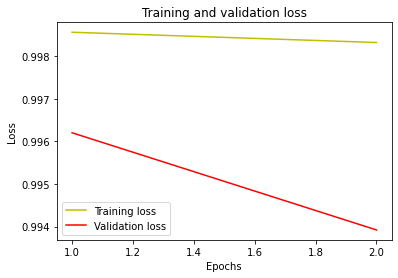

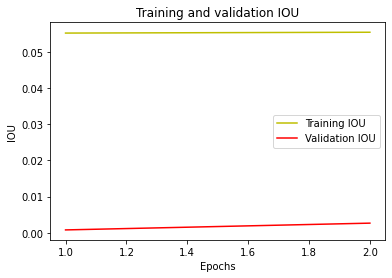

In [19]:
#plot the training and validation accuracy and loss at each epoch of the VGG16 trained_model

loss = history2_updated_by_5.history['loss']
val_loss = history2_updated_by_5.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2_updated_by_5.history['iou_score']
val_acc = history2_updated_by_5.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [20]:
#IOU

y_pred1 = new_model2.predict(X_test2) # only gives probabilities;
y_pred1_argmax = np.argmax(y_pred1, axis = 3) # returns the max. probability on the (axis=3) --> 3rd axis, thus saying what class it belongs;

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

5/5 [==============================] - 9s 2s/step
Mean IoU = 0.14639768


In [21]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)


[[  13484.   57985.  205945.   79338.]
 [   3707.   35640.  114892.   47468.]
 [  28438.  458473. 1133334.  380065.]
 [   3309.   10847.   36234.   12281.]]
IoU for class1 is:  0.034379892
IoU for class2 is:  0.048888084
IoU for class3 is:  0.4807598
IoU for class4 is:  0.02156294


1/1 [==============================] - 0s 96ms/step


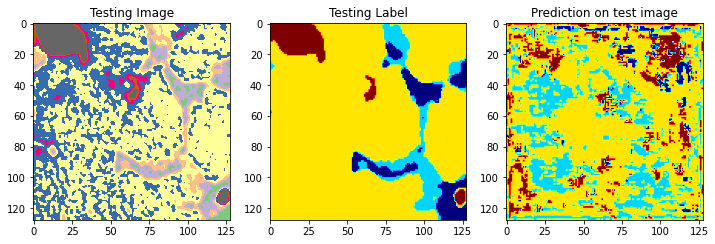

In [23]:
# Test some random images
import random
test_img_number = random.randint(0, len(X_test2))

test_img = X_test2[test_img_number]

ground_truth = y_test[test_img_number]

test_img_input = np.expand_dims(test_img, 0)

test_img_input3 = preprocess_input2(test_img_input)

test_pred3 = new_model2.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='Accent')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction3, cmap='jet')
plt.show()